# Example 1. Difussion 

This example aim to set up a simple diffussion problem for demostrating the workflow of running the problem on CPU and also ploting the result

In [1]:
using MHDFlows,PyPlot
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 4 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/DtzuG/src/FourierFlows.jl:123


In [7]:
# Declare the problem on CPU
CPUprob  = MHDProblem(CPU();nx = 32,Lx = 2π,
                             ν = 1/10,
                            nν = 1,
                             η = 1/10, 
              # Timestepper and equation options
                            dt = 1/50,
                       stepper = "RK4",
              # Float type and dealiasing
                             T = Float64);
CPUprob

Problem
  ├─────────── grid: grid (on CPU)
  ├───── parameters: params
  ├────── variables: vars
  ├─── state vector: sol
  ├─────── equation: eqn
  ├────────── clock: clock
  └──── timestepper: RK4TimeStepper

In [3]:
# function of setting up the initial condition
function ProblemGenerator3D!(prob,L;N = prob.grid.nx)

  xx,yy,zz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = prob.grid.x[i];
    yy[i,j,k] = prob.grid.y[j];
    zz[i,j,k] = prob.grid.z[k];
  end
    
  sl=1; sk=1; sm=1; lamlkm=sqrt(sl.^2+sk.^2+sm.^2);

  ux = @. -0.5*(lamlkm*sl*cos(sk*xx).*sin(sl*yy).*sin(sm.*zz) +sm*sk*sin(sk*xx).*cos(sl*yy).*cos(sm.*zz));
  uy=  @.  0.5*(lamlkm*sk*sin(sk*xx).*cos(sl*yy).*sin(sm.*zz)-sm*sl*cos(sk*xx).*sin(sl*yy).*cos(sm.*zz));
  uz=  @.                 cos(sk*xx).*cos(sl*yy).*sin(sm.*zz);

  bx = @. fill(0.0,N,N,N);
  by = @. fill(0.0,N,N,N);
  bz = @. fill(0.0,N,N,N);

  
  copyto!(prob.vars.ux, ux);
  copyto!(prob.vars.uy, uy);
  copyto!(prob.vars.uz, uz);
  copyto!(prob.vars.bx, bx);
  copyto!(prob.vars.by, by);
  copyto!(prob.vars.bz, bz);
    
  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = prob.sol[:, :, :, prob.params.bx_ind];
  byh = prob.sol[:, :, :, prob.params.by_ind];
  bzh = prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
  mul!(bxh, prob.grid.rfftplan, prob.vars.bx);
  mul!(byh, prob.grid.rfftplan, prob.vars.by);
  mul!(bzh, prob.grid.rfftplan, prob.vars.bz);
  
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
  prob.sol[:, :, :, prob.params.bx_ind] .= bxh;
  prob.sol[:, :, :, prob.params.by_ind] .= byh;
  prob.sol[:, :, :, prob.params.bz_ind] .= bzh;

  MHDupdatevars!(prob);

  return nothing
    
end

ProblemGenerator3D! (generic function with 1 method)

In [4]:
#function for monitoring the energy
function KEfoo(prob)
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    return sum(vx.^2+vy.^2 + vz.^2)
end

function MEfoo(prob)
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    return sum(bx.^2+by.^2 + bz.^2)
end

KE = Diagnostic(KEfoo, CPUprob);
ME = Diagnostic(MEfoo, CPUprob);

In [5]:
# Set up the initial condition
ProblemGenerator3D!(CPUprob,2π);

# Actaul computation
for i = 1:100
    MHDupdatevars!(CPUprob);
    stepforward!(CPUprob, [KE, ME],1)
end

## Result

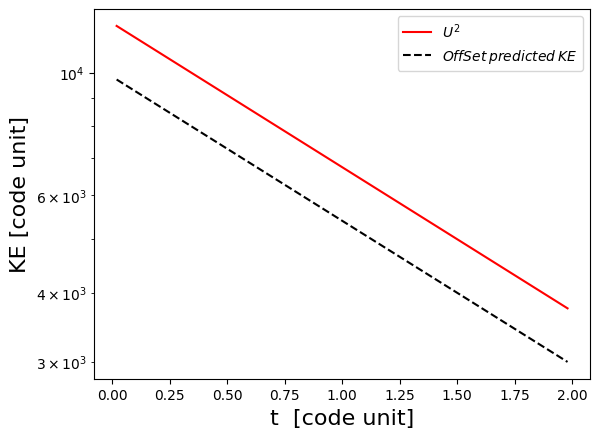

PyObject Text(30.0, 0.5, 'KE [code unit]')

In [6]:
t  = KE.t[2:end-1];
u0 = KE.data[2];
plot(KE.t[2:end-1],KE.data[2:end-1],"r",label=L"U^2")
semilogy(KE.t[2:end-1],exp.(-2*3*(t.-t[1])/10)*u0*0.8,"k--",label=L"OffSet\:predicted\:KE");
legend()
xlabel("t  [code unit]",size=16)
ylabel("KE [code unit]",size=16)